# Initial Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import deque
from collections.abc import Iterable
import tensorflow as tf
from tqdm import tqdm
from copy import deepcopy

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
energy_df = pd.read_csv("./trainData/energy consumption.csv")
site_df = pd.read_csv("./trainData/site information and grid outage.csv")
solar_df = pd.read_csv("./trainData/solar power and weather condition.csv")

In [3]:
sample_df = pd.read_csv("./SampleSubmission.csv")
sample_df.head()

,site name,time,grid,diesel,solar
0,site1,0,True,True,True
1,site1,1,True,True,True
2,site1,2,True,True,True
3,site1,3,True,True,True
4,site1,4,True,True,True


# Exploration

In [4]:
sample_df["site name"].value_counts()

site name
site1     672
site2     672
site3     672
site4     672
site5     672
site6     672
site7     672
site8     672
site9     672
site10    672
Name: count, dtype: int64

## Site Information

In [5]:
site_df

,Site Id,diesel power(kW),battery capacity (Ah),rated voltage（V）,battery charge coefficient,battery discharge coefficient,init SOC,DOD,grid power(kW),grid outage plan
0,site1,18.0,300,54,0.35,1.2,0.2,0.15,8,[false false false false false false false fal...
1,site2,17.6,760,54,0.35,1.2,0.2,0.15,14,[false false false false false false false fal...
2,site3,12.8,760,54,0.35,1.2,0.2,0.15,10,[false false false false false false false fal...
3,site4,17.6,760,54,0.35,1.2,0.2,0.15,14,[true true true true true true true true true ...
4,site5,17.6,380,54,0.35,1.2,0.2,0.15,12,[false false false false false true true true ...
5,site6,17.6,760,54,0.35,1.2,0.2,0.15,8,[false false false false false false false fal...
6,site7,18.0,380,54,0.35,1.2,0.2,0.15,8,[false false false false false false false fal...
7,site8,10.8,400,54,0.35,1.2,0.2,0.15,12,[false false false false false false false fal...
8,site9,12.8,400,54,0.35,1.2,0.2,0.15,8,[true true true true true true true true true ...
9,site10,17.6,380,54,0.35,1.2,0.2,0.15,10,[false false false false false true true true ...


In [6]:
# Grid outage cycle length (in hours)
site_outage = site_df["grid outage plan"].values
site_outage = site_outage[0][1:-1].split()
len(site_outage)

168

## Energy Consumption

In [7]:
energy_df["Site Name"].value_counts()

Site Name
site10    1440
site6     1440
site7     1440
site1     1440
site2     1440
site9     1440
site5     1440
site3     1440
site4     1440
site8     1440
Name: count, dtype: int64

In [8]:
# Energy consumption statistics for site 1
energy_df[energy_df["Site Name"] == "site1"].describe()

,Day,Hour,Total Energy(kWh)
count,1440.000000,1440.000000,1440.000000
mean,30.500000,11.500000,4.547507
std,17.324119,6.924591,0.542484
min,1.000000,0.000000,1.910000
25%,15.750000,5.750000,4.380000
50%,30.500000,11.500000,4.650000
75%,45.250000,17.250000,4.860000
max,60.000000,23.000000,5.590000


## Solar Statistics

In [9]:
# Solar power readings for site 1 day 1
solar_df.head(24)

,Site Name,Day,Hour,Solar Zenith Angle,Clearsky DHI,Clearsky DNI,Clearsky GHI,Relative Humidity,DHI,DNI,GHI,Energy Output(kWh)
0,site1,1,0,138.12,0.00,0.00,0.00,59.05,0.00,0.00,0.00,0.00
1,site1,1,1,125.23,0.00,0.00,0.00,62.04,0.00,0.00,0.00,0.00
2,site1,1,2,116.75,0.00,0.00,0.00,65.29,0.00,0.00,0.00,0.00
3,site1,1,3,97.86,0.00,0.00,0.00,63.05,0.00,0.00,0.00,0.00
4,site1,1,4,85.22,30.97,204.94,48.05,57.81,32.22,0.00,33.70,0.00
5,site1,1,5,72.65,84.11,575.39,270.87,47.83,136.88,5.11,135.23,0.24
6,site1,1,6,59.41,115.61,751.71,519.68,36.99,279.50,41.33,307.76,1.22
7,site1,1,7,43.31,132.24,855.50,733.84,32.99,434.51,164.39,525.67,4.14
8,site1,1,8,30.81,146.52,867.17,900.97,28.10,151.42,838.02,906.91,7.68
9,site1,1,9,18.25,142.87,917.78,974.32,26.87,137.94,914.59,1041.30,10.18


In [10]:
solar_df["Site Name"].value_counts()

Site Name
site1     1440
site10    1440
site2     1440
site3     1440
site4     1440
site5     1440
site6     1440
site7     1440
site8     1440
site9     1440
Name: count, dtype: int64

In [11]:
# Solar power statistics for site 1
solar_df[solar_df["Site Name"] == "site1"].describe()

,Day,Hour,Solar Zenith Angle,Clearsky DHI,Clearsky DNI,Clearsky GHI,Relative Humidity,DHI,DNI,GHI,Energy Output(kWh)
count,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000,1440.000000
mean,30.500000,11.500000,92.202896,39.940208,377.936674,284.848868,63.110708,69.879701,220.702799,212.745757,2.071391
std,17.324119,6.924591,44.906455,45.656950,415.277378,364.265628,21.934010,115.241758,358.994148,310.514167,2.851631
min,1.000000,0.000000,14.160000,0.000000,0.000000,0.000000,18.800000,0.000000,0.000000,0.000000,0.000000
25%,15.750000,5.750000,50.300000,0.000000,0.000000,0.000000,46.225000,0.000000,0.000000,0.000000,0.000000
50%,30.500000,11.500000,89.725000,0.000000,0.000000,0.000000,62.670000,0.000000,0.000000,0.000000,0.407000
75%,45.250000,17.250000,132.362500,84.207500,855.772500,640.737500,81.187500,89.842500,342.730000,387.950000,3.565000
max,60.000000,23.000000,175.370000,166.780000,1045.480000,1088.160000,103.760000,527.760000,1041.120000,1090.240000,11.609000


# Simulated Environment

## Environmental Statistics Organization

In [12]:
sites = site_df["Site Id"].tolist()
sites

['site1',
 'site2',
 'site3',
 'site4',
 'site5',
 'site6',
 'site7',
 'site8',
 'site9',
 'site10']

In [13]:
outage_plan_df = pd.DataFrame(columns=["site", "day", "hour", "outage"])
n = 0
for site_id, grid_outage_plan in site_df[["Site Id", "grid outage plan"]].values:
    grid_outage_plan = grid_outage_plan[1:-1].split()
    for i, outage in enumerate(grid_outage_plan):
        outage_plan_df.loc[n] = {"site": site_id, "day": (i//24)+1, "hour": i%24, "outage": 1 if outage == "true" else 0}
        n += 1
outage_plan_df.head()

,site,day,hour,outage
0,site1,1,0,0
1,site1,1,1,0
2,site1,1,2,0
3,site1,1,3,0
4,site1,1,4,0


In [14]:
# Site statistics organization format for simulated environment

site_statistics_example = {
    "site1": {
        # Site Information examples
        "diesel_power" : 34,
        "battery_info" : 76,
        "charge_coeff" : 34,
        "grid_power" : 3,
        "SOC & DOD" : 46,
        "outage_plan" : {
            "hour_interval" : [
                [1,3,5], # day 1 in hour chunks
                [2,4,6], # day 2 in hour chunks
            ],
            "15min_interval" : [
                [1,3,5], # day 1 in 15 min chunks
                [2,4,6], # day 2 in 15 min chunks
            ],

        "solar_power" : {}, # same format as outage plan
        # other solar power related features (same format as outage plan)

        "energy_consumption" : {}, # same format as outage plan
        } 
    }
}
# time of day should be a model feature (ranges from 0 to 23 for hour intervals and 0 to 95 for 15 minute intervals)

In [15]:
def interpolate_series(series, interval=4):
    new_series = []
    for i, num in enumerate(series):
        vals = np.linspace(series[i], series[i+1], interval+1)[:-1] if i < len(series)-1 else [series[i]]*interval
        new_series += list(vals)
    return new_series

In [16]:
def get_series_hourly_and_quarterly_chunks(series):
    hourly_chunks = series.reshape(-1, 24)
    series_quarterized = np.array(interpolate_series(series)).reshape(-1, 24*4)
    return {"hourly": np.cast["float32"](hourly_chunks), "quarterly": np.cast["float32"](series_quarterized)}

site_statistics = {}
# Energy is implicitly converted to power so the unit is kW, no transformation is needes since all the energy readings are hourly
for i in range(1, 10 + 1):
    site = f"site{i}"
    info = {}

    # Get site information
    for col in site_df.drop(columns=["Site Id", "grid outage plan"]).columns:
        info[col] = np.cast["float32"](site_df[site_df["Site Id"] == site][col].values)[0]

    # Get grid outage plan chunked into days. Available in hourly and quarter hourly intervals
    hourly_outages = np.array(outage_plan_df[outage_plan_df["site"] == site]["outage"].values)
    site_hourly_outage_plan = hourly_outages.reshape(-1, 24)
    quarter_hourly_outages = np.array(list(hourly_outages)*4).reshape(4, -1).T.flatten()
    site_quarter_hourly_outage_plan = quarter_hourly_outages.reshape(-1, 24*4)
    info["grid outage plan"] = {
        "hourly" : np.cast["float32"](site_hourly_outage_plan),
        "quarterly" : np.cast["float32"](site_quarter_hourly_outage_plan)
    }

    # Get energy consumption chunked into days. Available in hourly and quarter hourly intervals. Quarterly intervals are interpolated
    energy_demand = energy_df[energy_df["Site Name"] == site]["Total Energy(kWh)"].values
    info["Total Energy(kWh)"] = get_series_hourly_and_quarterly_chunks(energy_demand)

    # Get solar power and weather information chunked into days. Available in hourly and quarter hourly intervals. Quarterly intervals are interpolated
    for col in solar_df.drop(columns=["Site Name", "Day", "Hour"]).columns:
        readings = solar_df[solar_df["Site Name"] == site][col].values
        info[col] = get_series_hourly_and_quarterly_chunks(readings)
    
    site_statistics[site] = info

## Environment Class

In [17]:
class Environment():
    action_space = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])

    def __init__(
        self, 
        site_info, 
        init_soc : float = None,
        outage_plan_shift : int = 0,
        outage_plan_randomization : bool = False,
        energy_start_day : int = 1,
        energy_end_day : int = 60,
        energy_date_randomization : bool = False,
        solar_start_day : int = 1, 
        solar_end_day : int = 60, 
        solar_date_randomization : bool = False, 
        use_weather_data : bool = False,
        energy_solar_alignment : bool =True,
        quarterly_readings : bool = False,
        get_future_outages=0,
        get_past_states=0):

        self.site_info = site_info
        self.quarterly_readings = quarterly_readings

        self.get_past_states = get_past_states
        self.get_future_outages = get_future_outages
        self.state_buffer = {
            "energy": deque(maxlen=self.get_past_states),
            "solar": deque(maxlen=self.get_past_states)
        }

        if init_soc:
            if init_soc < 0 or init_soc > 100:
                raise ValueError("Initial state of charge must be between 0 and 1")
            elif init_soc < self.site_info["dod"]:
                raise ValueError("Initial state of charge must be greater than the depth of discharge")
            else:
                self.site_info["init_soc"] = init_soc
        

        outage_plan_shift = outage_plan_shift % 7
        outage_cycle = self.site_info["grid outage plan"]["quarterly" if quarterly_readings else "hourly"]
        outage_cycle = np.roll(outage_cycle, outage_plan_shift, axis=0)
        outage_cycle = np.random.permutation(outage_cycle) if outage_plan_randomization else outage_cycle
        self.outage_cycle = outage_cycle


        if energy_solar_alignment:
            solar_start_day = energy_start_day
            solar_end_day = energy_end_day
        if (solar_end_day - solar_start_day) != (energy_end_day - energy_start_day):
            raise ValueError("The number of days for solar and energy readings must be the same")
        if solar_end_day < solar_start_day:
            raise ValueError("The end day for solar readings must not be less than the start day")
        if energy_end_day < energy_start_day:
            raise ValueError("The end day for energy readings must not be less than the start day")

        energy_days_index = np.arange(energy_start_day-1, energy_end_day)
        energy_days_index = np.random.permutation(energy_days_index) if energy_date_randomization else energy_days_index
        energy_days = self.site_info["Total Energy(kWh)"]["quarterly" if quarterly_readings else "hourly"][energy_days_index]
        self.energy_days = energy_days

        solar_days_index = np.arange(solar_start_day-1, solar_end_day)
        if solar_date_randomization:
            solar_days_index = np.random.permutation(solar_days_index)
            solar_days_index = energy_days_index if energy_solar_alignment else solar_days_index
        solar_days = self.site_info["Energy Output(kWh)"]["quarterly" if quarterly_readings else "hourly"][solar_days_index]
        self.solar_days = solar_days

        self.use_weather_data = use_weather_data
        if use_weather_data:
            weather_data = []
            for i,col in enumerate(solar_df.drop(columns=["Site Name", "Day", "Hour", "Energy Output(kWh)"]).columns):
                self.state_buffer[f"weather_{i}"] = deque(maxlen=self.get_past_states)
                weather_data.append(self.site_info[col]["quarterly" if quarterly_readings else "hourly"][solar_days_index])
            self.weather_data = np.array(weather_data)

    def get_state(self):
        state = {
            "dod": self.site_info["DOD"],
            "battery_capacity": self.site_info["battery capacity (Ah)"],
            "charge_coefficient": self.site_info["battery charge coefficient"],
            "discharge_coefficient": self.site_info["battery discharge coefficient"],
            "diesel_power": self.site_info["diesel power(kW)"],
            "grid_power": self.site_info["grid power(kW)"],
            "rated_voltage": self.site_info["rated voltage（V）"],
            "timestep": self.time_step,
        }
        if self.get_future_outages:
            scale = 96 if self.quarterly_readings else 24
            step = self.time_step + ((self.day-1) % 7) * scale
            future_steps = step + self.get_future_outages
            temp = list(self.outage_cycle.flatten())
            future_outages = temp[step:future_steps]
            future_outages += temp[:future_steps%len(temp)] if future_steps > len(temp) else []
            state["outage"] = np.array(future_outages)
        else:
            state["outage"] = self.outage_cycle[(self.day-1) % 7][self.time_step]
        if self.get_past_states:
            self.state_buffer["energy"].append(self.energy_days[self.day-1][self.time_step])
            temp = list(self.state_buffer["energy"])
            temp = [0]*(self.get_past_states - len(temp)) + temp if len(temp) < self.get_past_states else temp
            state["energy"] = np.array(temp)

            self.state_buffer["solar"].append(self.solar_days[self.day-1][self.time_step])
            temp = list(self.state_buffer["solar"])
            temp = [0]*(self.get_past_states - len(temp)) + temp if len(temp) < self.get_past_states else temp
            state["solar"] = np.array(temp)

            if self.use_weather_data:
                for i,weather_data in enumerate(self.weather_data):
                    self.state_buffer[f"weather_{i}"].append(weather_data[self.day-1][self.time_step])
                    temp = list(self.state_buffer[f"weather_{i}"])
                    temp = [0]*(self.get_past_states - len(temp)) + temp if len(temp) < self.get_past_states else temp
                    state[f"weather_{i}"] = np.array(temp)
        else:
            state["energy"] = self.energy_days[self.day-1][self.time_step]
            state["solar"] = self.solar_days[self.day-1][self.time_step]
            if self.use_weather_data:
                for i,weather_data in enumerate(self.weather_data):
                    state[f"weather_{i}"] = weather_data[self.day-1][self.time_step]
        state["soc"] = self.soc
        return state

    def reset(self):
        self.day = 1
        self.time_step = 0
        self.soc = self.site_info["init SOC"]
        self.action_history = []
        self.reward_history = []
        self.soc_history = [self.soc]
        self.diesel_active_count = 0
        for key in self.state_buffer:
            self.state_buffer[key] = deque(maxlen=self.get_past_states)
        self.current_state = self.get_state()
        return self.current_state
    
    def get_final_score(self):
        diesel_usage = np.array(self.action_history)[:, 1]
        grid_usage = np.array(self.action_history)[:, 0]

        diesel_starts = 0
        prev = 0
        max_diesel_runtime = 0
        current_runtime = 0
        for i in diesel_usage:
            if i:
                current_runtime += 1
                max_diesel_runtime = max(max_diesel_runtime, current_runtime)
                if not prev:
                    diesel_starts += 1
            else:
                current_runtime = 0
            prev = i
        total_diesel_usage = diesel_usage.sum()
        total_grid_usage = grid_usage.sum()

        time_scale = 15 if self.quarterly_readings else 60
        score = (300*diesel_starts) + (1*total_diesel_usage*time_scale) + (0.95*max_diesel_runtime*time_scale) + (0.25*total_grid_usage*time_scale)
        return score
    
    def set_reward_params(self,
            diesel_start_penalty = -5,
            initial_diesel_penalty = -1,
            diesel_penalty_growth_rate = -1,
            grid_usage_penalty = -0.125,
            recharge_threshold = 0.6,
            discharge_threshold = 0.4,
            recharge_reward_weight = 2.5,
            discharge_penalty_weight = 5,):
        
        # Unclean energy penalties
        self.diesel_start_penalty = diesel_start_penalty
        self.initial_diesel_penalty = initial_diesel_penalty
        self.diesel_penalty_growth_rate = diesel_penalty_growth_rate
        self.grid_usage_penalty = grid_usage_penalty

        # Battery charge rewards and penalties
        self.recharge_threshold = recharge_threshold
        self.discharge_threshold = discharge_threshold
        self.recharge_reward_weight = recharge_reward_weight
        self.discharge_penalty_weight = discharge_penalty_weight

    def get_reward(self, action):
        reward = 0
    
        # Growing diesel penalty
        if action[1] and self.diesel_active_count > 0:
            scale = 1
            reward += self.initial_diesel_penalty + (self.diesel_penalty_growth_rate * self.diesel_active_count * scale)
            self.diesel_active_count += 1
        # Diesel start penalty
        if action[1] and self.diesel_active_count == 0:
            reward += self.diesel_start_penalty
            self.diesel_active_count += 1
        if not action[1]:
            self.diesel_active_count = 0
        # Grid usage penalty
        if action[0] and self.outage_cycle[(self.day-1) % 7][self.time_step]:
            reward += self.grid_usage_penalty

        eps = 1e-2
        prev_soc = self.soc_history[-1]
        # Battery recharge reward
        if prev_soc < self.recharge_threshold and self.soc > prev_soc:
            reward += (self.soc - prev_soc) * np.power(1 - prev_soc, 1) * self.recharge_reward_weight
        # Battery discharge penalty
        if self.soc < self.discharge_threshold and self.soc < prev_soc:
            reward += (self.soc - prev_soc) * np.power(1 - self.soc, 1) * self.discharge_penalty_weight
        
        return reward

    def step(self, action, direct_input=False):
        if not direct_input:
            action = self.action_space[action].copy()
        input_power = 0
        if action[0] and self.outage_cycle[(self.day-1) % 7][self.time_step]:
            input_power += self.site_info["grid power(kW)"]
        if action[1]:
            input_power += self.site_info["diesel power(kW)"]
        input_power += self.solar_days[self.day-1][self.time_step]
        power_demand = self.energy_days[self.day-1][self.time_step]
        power_generated = input_power - power_demand

        charge_coeff = self.site_info["battery charge coefficient"] if power_generated > 0 else self.site_info["battery discharge coefficient"]
        charge = (power_generated * charge_coeff) * 1000/(self.site_info["rated voltage（V）"] * self.site_info["battery capacity (Ah)"])
        charge /= 4 if self.quarterly_readings else 1
        self.soc += charge
        self.soc = min(1, max(self.site_info["DOD"], self.soc))

        reward = self.get_reward(action)
        self.reward_history.append(reward)
        self.soc_history.append(self.soc)
        self.action_history.append(action)
        
        fail = False
        if self.soc <= self.site_info["DOD"]:
            fail = True

        done = False
        self.time_step += 1
        if (self.time_step == 24*4 and self.quarterly_readings) or (self.time_step == 24 and not self.quarterly_readings):
            self.time_step = 0
            self.day += 1
        if self.day >= len(self.energy_days) + 1:
            done = True
        
        if not done:
            self.current_state = self.get_state()
        return self.current_state, reward, done, fail

In [18]:
0.1 * np.power(1 - 0.4, 2) * 100

3.5999999999999996

## State Preprocessing Functions

In [19]:
def decode_state(state):
    decoded_state = {
        "regular_input" : [],
        "future_outages" : [],
        "series_input" : []
    }
    for key, value in state.items():
        if not isinstance(value, Iterable):
            decoded_state["regular_input"].append([value])
        elif not key == "outage":
            decoded_state["series_input"].append(value[np.newaxis].T)
        else:
            decoded_state["future_outages"].append(value[np.newaxis].T)
    
    empty = []
    for key,value in decoded_state.items():
        if value:
            decoded_state[key] = np.array(decoded_state[key]).T
        else:
            empty.append(key)
    for key in empty:
        del decoded_state[key]
    return decoded_state

In [20]:
def engineer_state(state):
    state["input_grid_power"] = state["grid_power"] * state["outage"][0] if isinstance(state["outage"], Iterable) else state["grid_power"] * state["outage"]
    state["total_capacity"] = state["battery_capacity"] * state["rated_voltage"] / 1000
    energy_demand = state["energy"][-1] if isinstance(state["energy"], Iterable) else state["energy"]
    solar_power = state["solar"][-1] if isinstance(state["solar"], Iterable) else state["solar"]
    total_demand = energy_demand - solar_power

    power_states = [
        - total_demand,
        state["diesel_power"] - total_demand,
        state["input_grid_power"] - total_demand,
        state["diesel_power"] + state["input_grid_power"] - total_demand
    ]
    for i, power_state in enumerate(power_states):
        coeff = state["charge_coefficient"] if power_state > 0 else state["discharge_coefficient"]
        state[f"action_{i}_soc_change"] = (power_state * coeff) / (state["total_capacity"] * 4)
    
    return state

## Environment Testing

In [21]:
env = Environment(site_statistics["site1"], energy_end_day=1, get_past_states=3, get_future_outages=2)
state = env.reset()
env.set_reward_params({})
state

{'dod': 0.15,
 'battery_capacity': 300.0,
 'charge_coefficient': 0.35,
 'discharge_coefficient': 1.2,
 'diesel_power': 18.0,
 'grid_power': 8.0,
 'rated_voltage': 54.0,
 'timestep': 0,
 'outage': array([0., 0.], dtype=float32),
 'energy': array([0.        , 0.        , 4.48000002]),
 'solar': array([0., 0., 0.]),
 'soc': 0.2}

In [22]:
dec_state = decode_state(state)
dec_state

{'regular_input': array([[1.50000006e-01, 3.00000000e+02, 3.49999994e-01, 1.20000005e+00,
         1.80000000e+01, 8.00000000e+00, 5.40000000e+01, 0.00000000e+00,
         2.00000003e-01]]),
 'future_outages': array([[[0.],
         [0.]]], dtype=float32),
 'series_input': array([[[0.        , 0.        ],
         [0.        , 0.        ],
         [4.48000002, 0.        ]]])}

In [23]:
dec_eng_state = decode_state(engineer_state(state))
dec_eng_state["regular_input"].shape, dec_eng_state["series_input"].shape, dec_eng_state["future_outages"].shape

((1, 15), (1, 3, 2), (1, 2, 1))

In [24]:
state, reward, done, fail = env.step(2)
print(f"Reward: {reward}")
print(f"New State: {state}")
if done:
    print("Simulation Ended")
if fail:
    print("Simulation Failed")
if done or fail:
    print(f"Final Score: {env.get_final_score()}")

Reward: -0.21249998584389695
New State: {'dod': 0.15, 'battery_capacity': 300.0, 'charge_coefficient': 0.35, 'discharge_coefficient': 1.2, 'diesel_power': 18.0, 'grid_power': 8.0, 'rated_voltage': 54.0, 'timestep': 1, 'outage': array([0., 0.], dtype=float32), 'energy': array([0.        , 4.48000002, 4.30000019]), 'solar': array([0., 0., 0.]), 'soc': 0.15}
Simulation Failed
Final Score: 15.0


# Reinforcement Learning Algorithm

## Deep Q Class

In [25]:
class DeepQModel():
    def __init__(
            self, 
            base_model, 
            optimizer,
            loss_fn, 
            action_space,
            state_decoder=None, 
            buffer_size = 2000, 
            gamma = 0.95,):
        
        self.model = base_model
        self.target = tf.keras.models.clone_model(self.model)
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.state_decoder = state_decoder
        self.action_space = action_space
        self.memory = deque(maxlen=buffer_size)
        self.gamma = gamma

    def remember(self, state, action, reward, next_state, done, truncated):
        self.memory.append((state, action, reward, next_state, done, truncated))
    
    def sample_experiences(self, batch_size):
        indices = np.random.randint(len(self.memory), size=batch_size)
        batch = [self.memory[index] for index in indices]
        return [
            np.array([experience[field_index] for experience in batch])
            for field_index in range(6)
        ] # [states, actions, rewards, next_states, dones, truncateds]

    def epsilon_greedy_policy(self, state, epsilon):
        if np.random.rand() < epsilon:
            action_index = np.random.randint(len(self.action_space)) # random action
        else:
            Q_values = self.model(state)[0]
            action_index = np.argmax(Q_values) # optimal action according to the DQN
        return action_index
    
    def play_one_step(self, env, state, epsilon, training=True):
        if self.state_decoder: state = self.state_decoder(state)
        action = self.epsilon_greedy_policy(state, epsilon)
        next_state, reward, done, truncated = env.step(action)
        if training: self.remember(state, action, reward, self.state_decoder(next_state) if self.state_decoder else next_state, done, truncated)
        return next_state, reward, done, truncated
    
    def training_step(self, batch_size, track_loss=False):
        states, actions, rewards, next_states, dones, truncateds = self.sample_experiences(batch_size)
        runs = 1.0 - (dones | truncateds) # episode is not done or truncated

        if isinstance(states[0], dict):
            s = {key: np.array([state[key][0].tolist() for state in states]) for key in states[0]}
            ns = {key: np.array([state[key][0].tolist() for state in next_states]) for key in next_states[0]}
            states, next_states = s, ns
        
        # Double DQN
        next_Q_values = self.model.predict(next_states, verbose=0) # ≠ target.predict()
        best_next_actions = next_Q_values.argmax(axis=1)
        next_mask = tf.one_hot(best_next_actions, len(self.action_space)).numpy()
        max_next_Q_values = (self.target.predict(next_states, verbose=0) * next_mask).sum(axis=1)
                
        target_Q_values = rewards + runs * self.gamma * max_next_Q_values
        target_Q_values = target_Q_values.reshape(-1, 1)
        
        mask = tf.one_hot(actions, len(self.action_space))
        with tf.GradientTape() as tape:
            all_Q_values = self.model(states, training=True)
            Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
            loss = tf.reduce_mean(self.loss_fn(target_Q_values, Q_values))
        
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        if track_loss:
            return loss.numpy()

    def load(self, path):
        self.model.load_weights(path)
        self.update_target()

    def save(self, path):
        self.model.save_weights(path)
    
    def update_target(self):
        self.target.set_weights(self.model.get_weights())

## Training Experiments

In [83]:
# Setup
def decoder(state):
    return decode_state(engineer_state(state))

reward_params = {
    "diesel_start_penalty" : -1.,
    "initial_diesel_penalty" : -0.5,
    "diesel_penalty_growth_rate" : -0.1,
    "grid_usage_penalty" : -0.2,
    "recharge_threshold" : 0.8,
    "discharge_threshold" : 0.5,
    "recharge_reward_weight" : 80,
    "discharge_penalty_weight" : 80.
}

### Deep Q Model Training

In [70]:
def run_dq_training_sim(
        dqmodel,
        sites,
        env_params,
        randomize_days,
        reward_params,
        num_episodes,
        num_steps,
        lr,
        final_lr=None,
        batch_size=32,
        min_epsilon=0.01,
        epsilon_threshold=0.8,
        target_update_interval=25,
        save_path=None
    ):
    
    reward_history = np.array([])
    survival_history = np.array([])
    score_history = np.array([])
    losses = ([])
    lr_factor = (final_lr/lr)**(1/num_episodes) if final_lr else None
    day_steps = 96 if env_params["quarterly_readings"] else 24
    num_days = num_steps//day_steps

    # Training Simulation
    for episode in tqdm(range(num_episodes), ncols=100):
        env_params["site_info"] = site_statistics[sites[episode % len(sites)]] # Pick a site in order
        if randomize_days:
            env_params["energy_start_day"] = np.random.randint(1, 60-num_days+2)
            env_params["energy_end_day"] = env_params["energy_start_day"] + num_days - 1
        env = Environment(**env_params)
        env.set_reward_params(**reward_params)
        obs = env.reset()

        episode_rewards = 0
        episode_length = 0
        if final_lr: dqmodel.optimizer.learning_rate = lr * (lr_factor**episode)

        for step in range(num_steps):
            epsilon = max(1 - episode / (num_episodes*epsilon_threshold), min_epsilon)
            obs, reward, done, fail = dqmodel.play_one_step(env, obs, epsilon)

            episode_rewards += reward
            episode_length += 1

            if done or fail:
                break
        
        episode_score = env.get_final_score()
        score_history = np.r_[score_history, episode_score]
        reward_history = np.r_[reward_history, episode_rewards]
        survival_history = np.r_[survival_history, episode_length]
        
        if episode > num_episodes//10:
            losses = np.r_[losses, dqmodel.training_step(batch_size, track_loss=True)]
        
        if (episode+1 % target_update_interval) == 0:
            dqmodel.update_target()

    avg_reward_history = reward_history/survival_history
    weighted_score_history = score_history*num_steps/survival_history

    if save_path: dqmodel.save(save_path)

    plt.figure()
    plt.plot(survival_history)
    plt.title("Survival History")
    
    plt.figure()
    plt.plot(avg_reward_history)
    plt.title("Reward History (Averaged)")

    plt.figure()
    plt.plot(weighted_score_history)
    plt.title("Score History (Weighted by survival)")

    return survival_history, avg_reward_history, weighted_score_history, losses

In [84]:
num_days = 7
quarterly = True
env_params = {
    "site_info" : site_statistics[sites[0]],
    "quarterly_readings" : quarterly,
    "get_future_outages" : 12,
    "get_past_states" : 16
}

env = Environment(**env_params)
env.set_reward_params(**reward_params)
env.reset()
sample_state = decoder(env.step(0)[0])
regular_input_shape = sample_state["regular_input"].shape
series_input_shape = sample_state["series_input"].shape
future_outages_shape = sample_state["future_outages"].shape

# Dueling DQN
tf.random.set_seed(42)
regular_input = tf.keras.layers.Input(shape=[regular_input_shape[-1]], name="regular_input")
series_input = tf.keras.layers.Input(shape=[None, series_input_shape[-1]], name="series_input")
future_outages_input = tf.keras.layers.Input(shape=[None, future_outages_shape[-1]], name="future_outages")

series_lstm = tf.keras.layers.LSTM(16)(series_input)
outages_lstm = tf.keras.layers.LSTM(16)(future_outages_input)
combined_layer = tf.keras.layers.Concatenate()([regular_input, series_lstm, outages_lstm])
batch_norm = tf.keras.layers.BatchNormalization()(combined_layer)

hidden1 = tf.keras.layers.Dense(32, activation="swish", kernel_initializer="he_normal")(batch_norm)
hidden2 = tf.keras.layers.Dense(32, activation="swish", kernel_initializer="he_normal")(hidden1)
state_values = tf.keras.layers.Dense(1)(hidden2)
raw_advantages = tf.keras.layers.Dense(len(env.action_space))(hidden2)
advantages = raw_advantages - tf.reduce_max(raw_advantages, axis=1, keepdims=True)
Q_values = state_values + advantages
model = tf.keras.Model(inputs=[regular_input, series_input, future_outages_input], outputs=[Q_values])

initial_lr = 1e-2
# final_lr = 1e-3
optimizer = tf.keras.optimizers.Nadam(learning_rate=initial_lr, weight_decay=1e-3)
loss_fn = tf.keras.losses.mean_squared_error

dqn = DeepQModel(
    model, 
    optimizer, 
    loss_fn, 
    env.action_space,
    state_decoder=decoder,
    buffer_size=6720, 
    gamma=0.8)

num_steps = num_days*96 if quarterly else num_days*24
batch_size = 128
num_episodes = 200
min_epsilon = 0.01
epsilon_threshold = 0.8
update_interval = 10
experiment_name = ""
ckpt_path = f"./dqn_ckpt/{experiment_name}/weights" if experiment_name else None

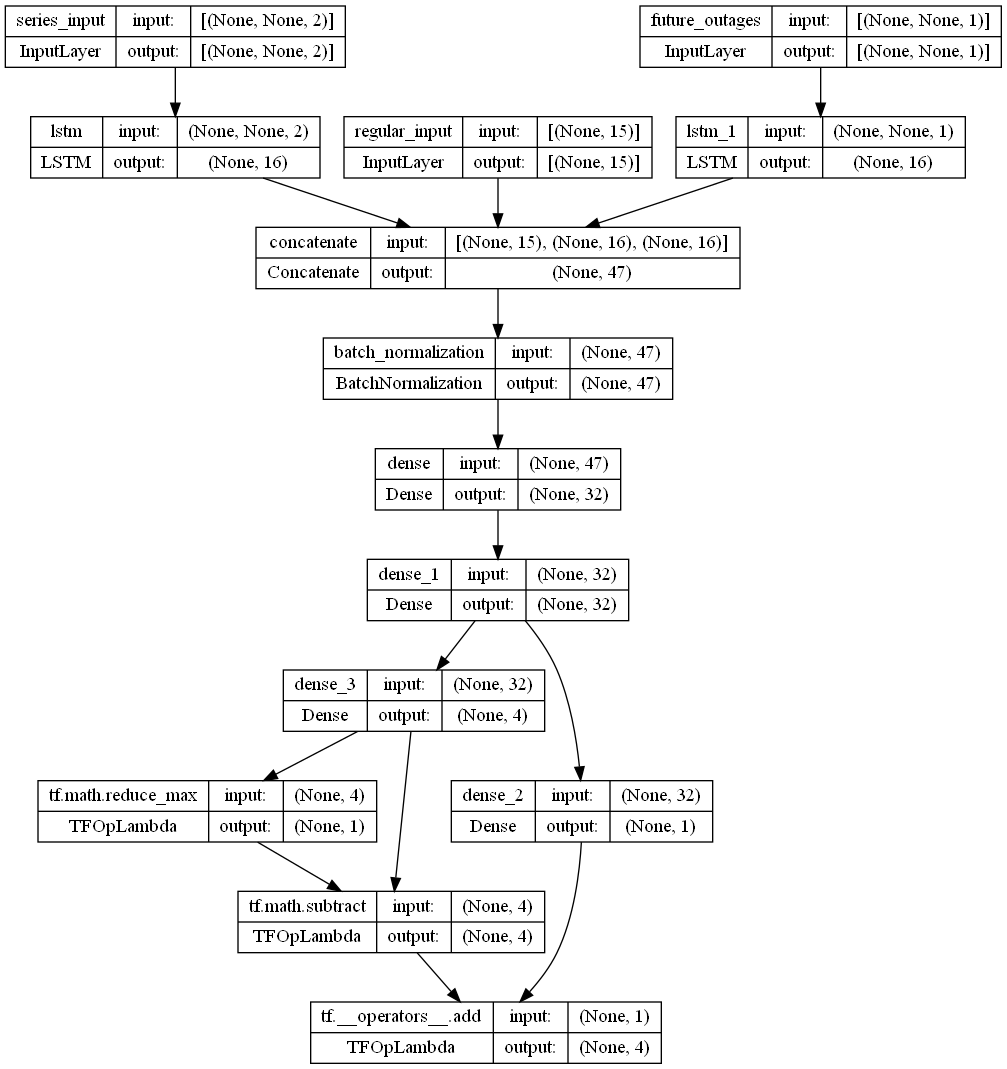

In [72]:
model(sample_state)
tf.keras.utils.plot_model(model, show_shapes=True)

100%|█████████████████████████████████████████████████████████████| 200/200 [40:47<00:00, 12.24s/it]


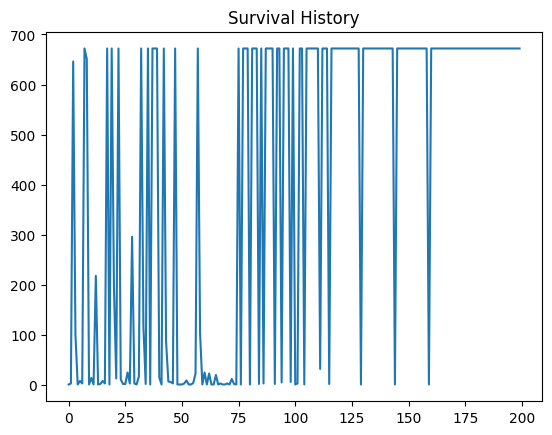

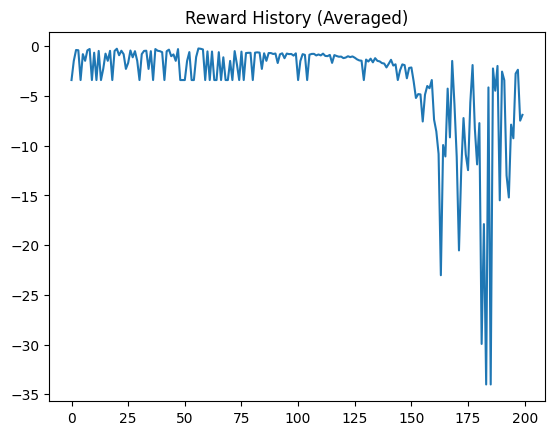

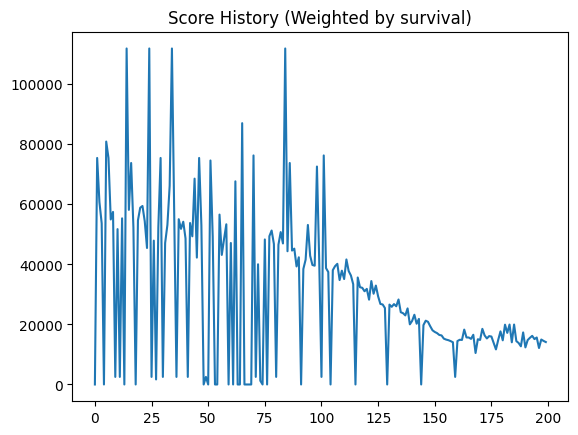

In [85]:
survival_history, avg_reward_history, weighted_score_history, losses = run_dq_training_sim(
    dqmodel=dqn,
    sites=sites,
    env_params=env_params,
    reward_params=reward_params,
    num_episodes=num_episodes,
    num_steps=num_steps,
    randomize_days=True,
    lr=initial_lr,
    # final_lr=final_lr,
    batch_size=batch_size,
    min_epsilon=min_epsilon,
    epsilon_threshold=epsilon_threshold,
    target_update_interval=update_interval,
    save_path=ckpt_path
)

### Model Evaluation

In [74]:
def run_evaluation_sim(dqmodel, sites, test_params, test_days):
    baseline_score = 0
    test_scores = []
    timesteps_survived = []
    scale = 4 if test_params["quarterly_readings"] else 1

    for site in sites:
        test_params["site_info"] = site_statistics[site]
        test_env = Environment(**test_params)
        test_env.set_reward_params()
        test_env.reset()

        # Baseline Strategy Evaluation (Use all energy sources)
        for _ in range(test_days*24*scale):
            test_env.step(3)
        baseline_score += test_env.get_final_score()
        
        # Model Strategy Evaluation
        days = 0
        obs = test_env.reset()
        for _ in tqdm(range(test_days*scale*24), desc=site):
            obs, reward, done, fail = dqn.play_one_step(test_env, obs, 0, training=False)
            days += 1
            if done or fail:
                break
        timesteps_survived.append(days)
        test_scores.append(test_env.get_final_score())

    baseline_score = baseline_score/len(sites)
    timesteps_survived = np.array(timesteps_survived)
    test_scores = np.array(test_scores)
    avg_score = (test_scores*test_days*scale*24/timesteps_survived).mean()

    print(f"Timesteps Survived: {timesteps_survived}")
    print(f"Test Scores: {test_scores}")
    print(f"Baseline Average Score: {baseline_score}")
    print(f"Model Average Score: {avg_score}")

    return timesteps_survived, test_scores, baseline_score, avg_score

In [92]:
test_sites = ["site1", "site2", "site3", "site4", "site5", "site6", "site7", "site8", "site9", "site10"]
test_days = 7
test_start_day = 50
test_params = {
    "energy_start_day" : test_start_day,
    "energy_end_day" : test_days + test_start_day + 1,
    "quarterly_readings" : True,
    "get_past_states" : 16,
    "get_future_outages" : 12
}

timesteps_survived, test_scores, baseline_score, model_avg_score = run_evaluation_sim(
    dqmodel=dqn,
    sites=test_sites,
    test_params=test_params,
    test_days=test_days
)

site10: 100%|██████████| 672/672 [00:24<00:00, 27.02it/s]

Timesteps Survived: [672 672 672 672 672 672 672 672 672 672]
Test Scores: [16125.75 19956.   19956.   19956.   19956.   19956.   14742.75 19956.
 19956.   16587.  ]
Baseline Average Score: 22476.0
Model Average Score: 18714.75


# Metaheuristic Algorithm Experiment

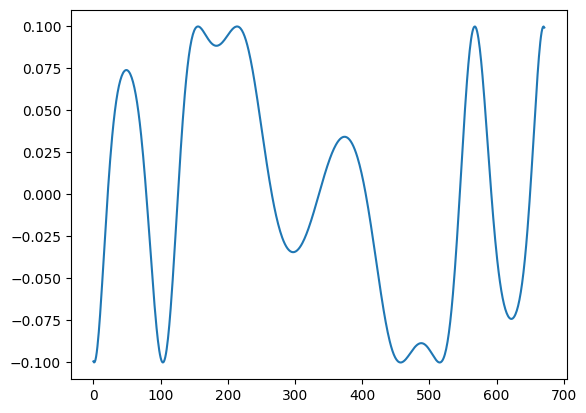

In [27]:
# Angle Modulation Particle Swarm Optimization
a, b, c, d, e, alpha1, alpha2 = 0., 0.5, 0.8, 0, 0.1, -1.5, 1.5
n = 672

x = np.linspace(alpha1, alpha2, n)
# x = np.arange(0, n, dtype=np.float32)
y = e*np.sin(2*np.pi*(x-a) * b*np.cos(2*np.pi*c*(x-a))) + d

plt.plot(y)

## Evaluation Environment

In [28]:
class MHTrainingEnvironment():
    def __init__(self,env):
        self.env = env
        self.env.set_reward_params()
    def get_baseline(self):
        self.env.reset()
        done = False
        while not done:
            _, _, done, _ = self.env.step(3)
        return self.env.get_final_score()
    def score_solution(self, solution):
        solution = solution.reshape(-1, 2)
        self.env.reset()
        done = False
        fail = False
        steps = 0
        while not(done or fail):
            _, _, done, fail = self.env.step(solution[steps], direct_input=True)
            steps += 1
        # self.env.action_history = solution
        score = self.env.get_final_score() if done else 20_000_000 / steps
        return -score

## Angle Modulation PSO

In [29]:
from metaheuristics import AMPSO

env = Environment(site_statistics["site10"], energy_end_day=7, quarterly_readings=True)
mh_env = MHTrainingEnvironment(env)
ampso = AMPSO(
    num_bits=672*2,
    swarm_size=1000,
    inertia=[0.999, 0.92],
    cogn_coeff=[0.001, 0.04],
    soc_coeff=[0.001, 0.04],
)
ampso.run(eval_func=mh_env.score_solution, max_iter=200, verbose=False)

In [30]:
mh_env.get_baseline()

22476.0

In [32]:
abs(mh_env.score_solution(ampso.get_solution(ampso.best_solution)))

11574.75

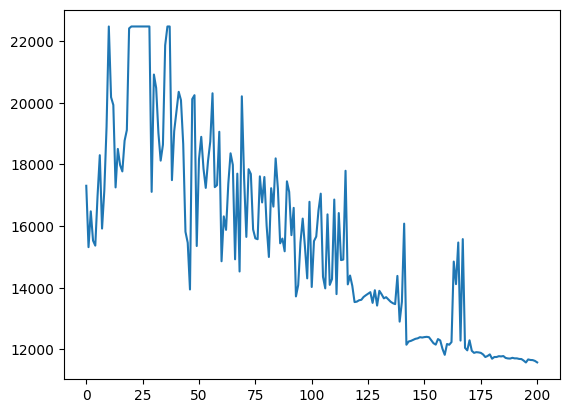

In [33]:
plt.plot(np.abs(ampso.history["score"]))

# Hard coded policy

In [34]:
start_day = 54
num_days = 7
scores = []
rewards = []
days_survived = []
soc_histories = []
for site in sites:
    env = Environment(site_statistics[site], energy_start_day=start_day, energy_end_day=start_day+num_days-1, quarterly_readings=True)
    env.set_reward_params()
    charging = False
    charge_threshold = 0.3
    discharge_threshold = 0.9
    state = env.reset()
    done = fail = False
    total_reward = 0
    steps = 0
    while not (done or fail):
        action = [0,0]
        if state["soc"] < charge_threshold and not charging:
            charging = True
        elif state["soc"] > discharge_threshold and charging:
            charging = False
        if charging:
            action = [1,1] # (Grid: True, Diesel: True)
        else:
            action = [1,0] # (Grid: True, Diesel: False)
        action[0] = state["outage"]
        # action[1] = abs(1-action[0])
        # action = [1,1]
        state, reward, done, fail = env.step(action, direct_input=True)
        steps += 1
        total_reward += reward
    scores.append(env.get_final_score())
    rewards.append(total_reward)
    days_survived.append(steps)
    soc_histories.append(env.soc_history)
print(f"Scores: {scores}")
print(f"Rewards: {rewards}")
print(f"Days Survived: {days_survived}")
print(f"Average Score: {np.mean(scores)}")

Scores: [10177.5, 9030.75, 5656.5, 7935.0, 9600.75, 6716.25, 5766.0, 2775.75, 7125.75, 6065.25]
Rewards: [-1091.8346022114802, -4989.929096553044, -2592.350552280734, -4266.098793365624, -1844.201893782305, -2157.9416358847075, -724.8842987374405, -517.5356807315023, -1712.7745672123785, -765.6684300695291]
Days Survived: [672, 672, 672, 672, 672, 672, 672, 672, 672, 672]
Average Score: 7084.95


(0.15, 1.0399999998509883)

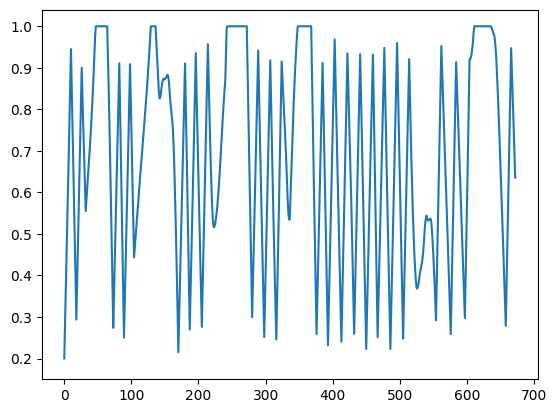

In [35]:
plt.plot(soc_histories[0])
plt.ylim(0.15)